# Beat detection
In this tutorial we will learn how to detect beats in PPG and BP signals.

The **objectives** are:
- To learn how to call Python functions which are stored in a separate file
- To use several beat detection algorithms to detect beats in PPG and BP signals
- To compare their performance

<div class="alert alert-block alert-warning"> <b>Context:</b> A key step in analysing PPG and BP signals is the detection of beats in the signals. This allows individual pulse waves to be analysed, and either: (i) features to be extracted from PPG pulse waves; or (ii) reference BP values to be extracted from BP pulse waves. </div>

---
## Setup

- Specify the required Python packages

In [72]:
import sys
import numpy as np
import scipy.signal as sp

from matplotlib import pyplot as plt

import wfdb

- Specify the settings for the MIMIC-III database

In [73]:
wfdb.set_db_index_url('https://physionet.org/files') # use the version of the WFDB toolbox which corresponds to MIMIC IV.
database_name = 'mimic3wdb/1.0' # The name of the MIMIC III Waveform Database on Physionet (see URL: https://physionet.org/content/mimic3wdb/1.0/)

- Provide a list of segments which meet the requirements for the study

In [74]:
segment_names = ['3000063_0013']
segment_dirs = ['mimic3wdb/1.0/30/3000063/']

- Specify a segment from which to extract data

In [75]:
rel_segment_no = 0
rel_segment_name = segment_names[rel_segment_no]
rel_segment_dir = segment_dirs[rel_segment_no]
print("Specified segment '{}' in directory '{}'".format(rel_segment_name, rel_segment_dir))

Specified segment '3000063_0013' in directory 'mimic3wdb/1.0/30/3000063/'


---
## Extract data
Extract data from this segment

- Specify the duration to be extracted

In [76]:
start_time = 60 # time since the start of the segment at which to begin extracting data
no_seconds_to_load = 10

- Find out the sampling frequency of the waveform data

In [77]:
segment_metadata = wfdb.rdheader(record_name=rel_segment_name, pn_dir=rel_segment_dir)
fs = segment_metadata.fs
print("Sampling frequency is {} Hz".format(fs))

Sampling frequency is 125 Hz


- Extract this duration of signals from the longer segment

In [78]:
segment_data = wfdb.rdrecord(record_name = rel_segment_name, sampfrom = fs*start_time, sampto = fs*(start_time + no_seconds_to_load), pn_dir = rel_segment_dir) 
print("{} seconds of data loaded from segment '{}'".format(no_seconds_to_load, rel_segment_name))

10 seconds of data loaded from segment '3000063_0013'


- Plot the extracted data

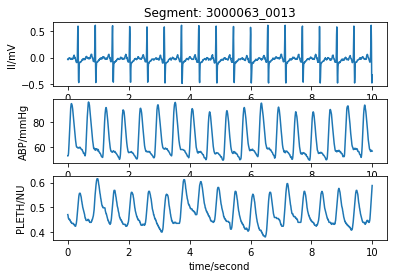

In [79]:
title_text = "Segment: " + rel_segment_name
wfdb.plot_wfdb(record=segment_data, title=title_text, time_units='seconds') 

<div class="alert alert-block alert-warning"> <b>Explanation:</b>
    This plot shows 10 seconds of data exracted from a longer segment. It contains three simultaneously recorded signals:
        <ul>
            <li> II: The ECG signal (lead II), measured in mV
            <li> ABP: The arterial blood pressure signal, measured in mmHg
            <li> PLETH: The photoplethysmogram (a.k.a PPG) signal, measured in (?) normalised units
        </ul>
</div>

- Extract the ABP and PPG signals

In [80]:
abp_col = []
ppg_col = []
for sig_no in range(0,len(segment_data.sig_name)):
    if "ABP" in segment_data.sig_name[sig_no]:
        abp_col = sig_no
    if "PLETH" in segment_data.sig_name[sig_no]:
        ppg_col = sig_no
abp = segment_data.p_signal[:,abp_col]
ppg = segment_data.p_signal[:,ppg_col]
fs = segment_data.fs
print("Extracted the ABP signal from column {} of the matrix of waveform data.".format(abp_col))
print("Extracted the PPG signal from column {} of the matrix of waveform data.".format(ppg_col))
print("Both are sampled at {} Hz.".format(segment_data.fs))

Extracted the ABP signal from column 1 of the matrix of waveform data.
Extracted the PPG signal from column 2 of the matrix of waveform data.
Both are sampled at 125 Hz.


---
## Filter the BP and PPG signals

- Import the [SciPy signal processing package](https://docs.scipy.org/doc/scipy/tutorial/signal.html), which contains functions for filtering and differentiating.

In [81]:
import scipy.signal as sp

- Filter the PPG and BP signals in preparation for beat detection.

In [82]:
sos_filter = sp.butter(10, [0.7, 10], btype = 'bp', analog = False, output = 'sos', fs = segment_data.fs)
ppg_filt = sp.sosfiltfilt(sos_filter, ppg)
abp_filt = sp.sosfiltfilt(sos_filter, abp)

- We will use the filtered signals instead of the originals from now on.

---
## Beat detection

### Setup

- Import the functions required to detect beats (from [this file](https://github.com/wfdb/mimic_wfdb_tutorials/blob/main/content/tutorial/notebooks/beat_detection_functions.py)):

In [83]:
%run beat_detection_functions

<div class="alert alert-block alert-info"> <b>Question:</b> How have these functions been stored? </div>

### Detect beats in the PPG signal

- Detect beats in the PPG signal using three beat detector algorithms:

In [84]:
ppg_ibis_d2max = pulse_detect(ppg_filt,fs,5,'d2max')
ppg_ibis_upslopes = pulse_detect(ppg_filt,fs,5,'upslopes')
ppg_ibis_delineator = pulse_detect(ppg_filt,fs,5,'delineator')
print("Detected {} beats in the PPG signal using the {} algorithm".format(len(ppg_ibis_d2max), "D2max"))
print("Detected {} beats in the PPG signal using the {} algorithm".format(len(ppg_ibis_upslopes), "Upslopes"))
print("Detected {} beats in the PPG signal using the {} algorithm".format(len(ppg_ibis_delineator), "Delineator"))

Detected 17 beats in the PPG signal using the D2max algorithm
Detected 16 beats in the PPG signal using the Upslopes algorithm
Detected 16 beats in the PPG signal using the Delineator algorithm


- Plot the results:

Text(0.5, 1.0, 'Delineator')

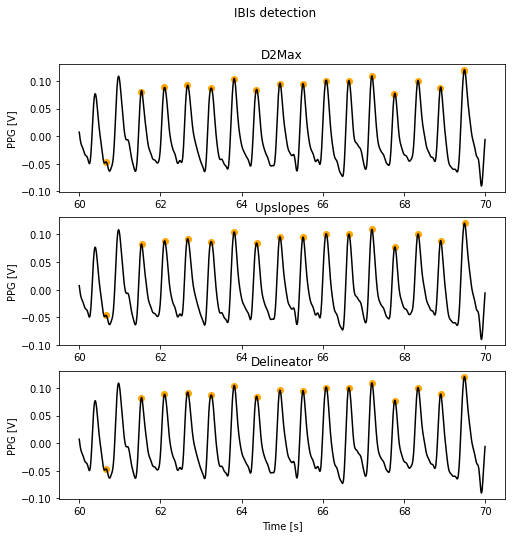

In [85]:
from matplotlib import pyplot as plt
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = False, sharey = False, figsize = (8,8))
fig.suptitle('IBIs detection') 

t = np.arange(start_time,(start_time + no_seconds_to_load),1.0/fs)

ax1.plot(t, ppg_filt, color = 'black')
ax1.scatter(t[0] + ppg_ibis_d2max/fs, ppg_filt[ppg_ibis_d2max], color = 'orange', marker = 'o')
ax1.set_ylabel('PPG [V]')
ax1.set_title('D2Max')

ax2.plot(t, ppg_filt, color = 'black')
ax2.scatter(t[0] + ppg_ibis_upslopes/fs, ppg_filt[ppg_ibis_upslopes], color = 'orange', marker = 'o')
ax2.set_ylabel('PPG [V]')
ax2.set_title('Upslopes')

ax3.plot(t, ppg_filt, color = 'black')
ax3.scatter(t[0] + ppg_ibis_delineator/fs, ppg_filt[ppg_ibis_delineator], color = 'orange', marker = 'o')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('PPG [V]')
ax3.set_title('Delineator')

We'll use the 'D2max' algorithm in the rest of this tutorial

### Detect beats in the BP signal

In [86]:
abp_ibis_d2max = pulse_detect(abp_filt,fs,5,'d2max')

### Plot the results

Text(0, 0.5, 'ABP [au]')

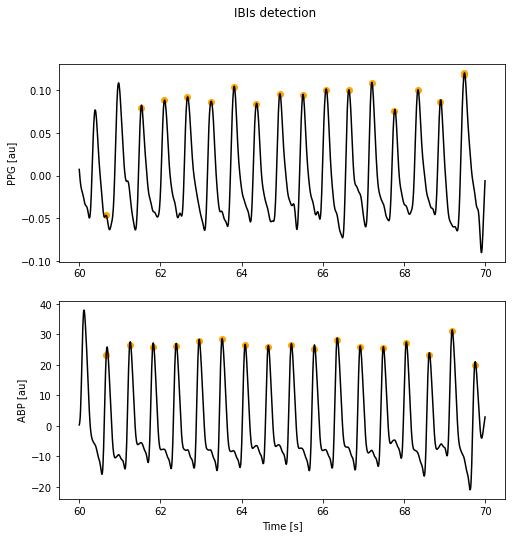

In [87]:
from matplotlib import pyplot as plt
fig, (ax1,ax2) = plt.subplots(2, 1, sharex = False, sharey = False, figsize = (8,8))
fig.suptitle('IBIs detection') 

t = np.arange(start_time,(start_time + no_seconds_to_load),1.0/fs)

ax1.plot(t, ppg_filt, color = 'black')
ax1.scatter(t[0] + ppg_ibis_d2max/fs, ppg_filt[ppg_ibis_d2max], color = 'orange', marker = 'o')
ax1.set_ylabel('PPG [au]')

ax2.plot(t, abp_filt, color = 'black')
ax2.scatter(t[0] + abp_ibis_d2max/fs, abp_filt[abp_ibis_d2max], color = 'orange', marker = 'o')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('ABP [au]')

<div class="alert alert-block alert-info"> <b>Question:</b> In which signal were the beats detected more accurately? Why might this be the case?</div>